# Reconocimiento de Patrones
[Curso de Reconocimiento de Patrones]

Departamento Electrónica

Universidad Popular del Cesar

JOsé Ramón Iglesias Gamarra



# Ejemplo: Reconocimiento Facial con LBP

En este ejemplo se muestra cómo usar LBP en el reconocimiento facial. Este método ha sido muy usado en caras frontales y bien alineadas.

Referencias:

* [Paper sobre Local Binary Patterns](https://www.dropbox.com/s/qnbawxl9i4j2vv9/LBP_faces.pdf?dl=0)



En este ejemplo se realiza el reconocimiento facial en una base de datos muy conocida(*) que contiene 40 personas y cada una de ellas con 10 fotos faciales. Esta base de datos es conocida por ser "fácil", ya que las fotos son de caras frontales y tomadas en el mismo día, lo cual indica que no hay muchos cambios de apariencia dentro de las 10 fotos de cada persona. Aquí algunos ejemplos.


(*) [ORL database](https://paperswithcode.com/dataset/orl)



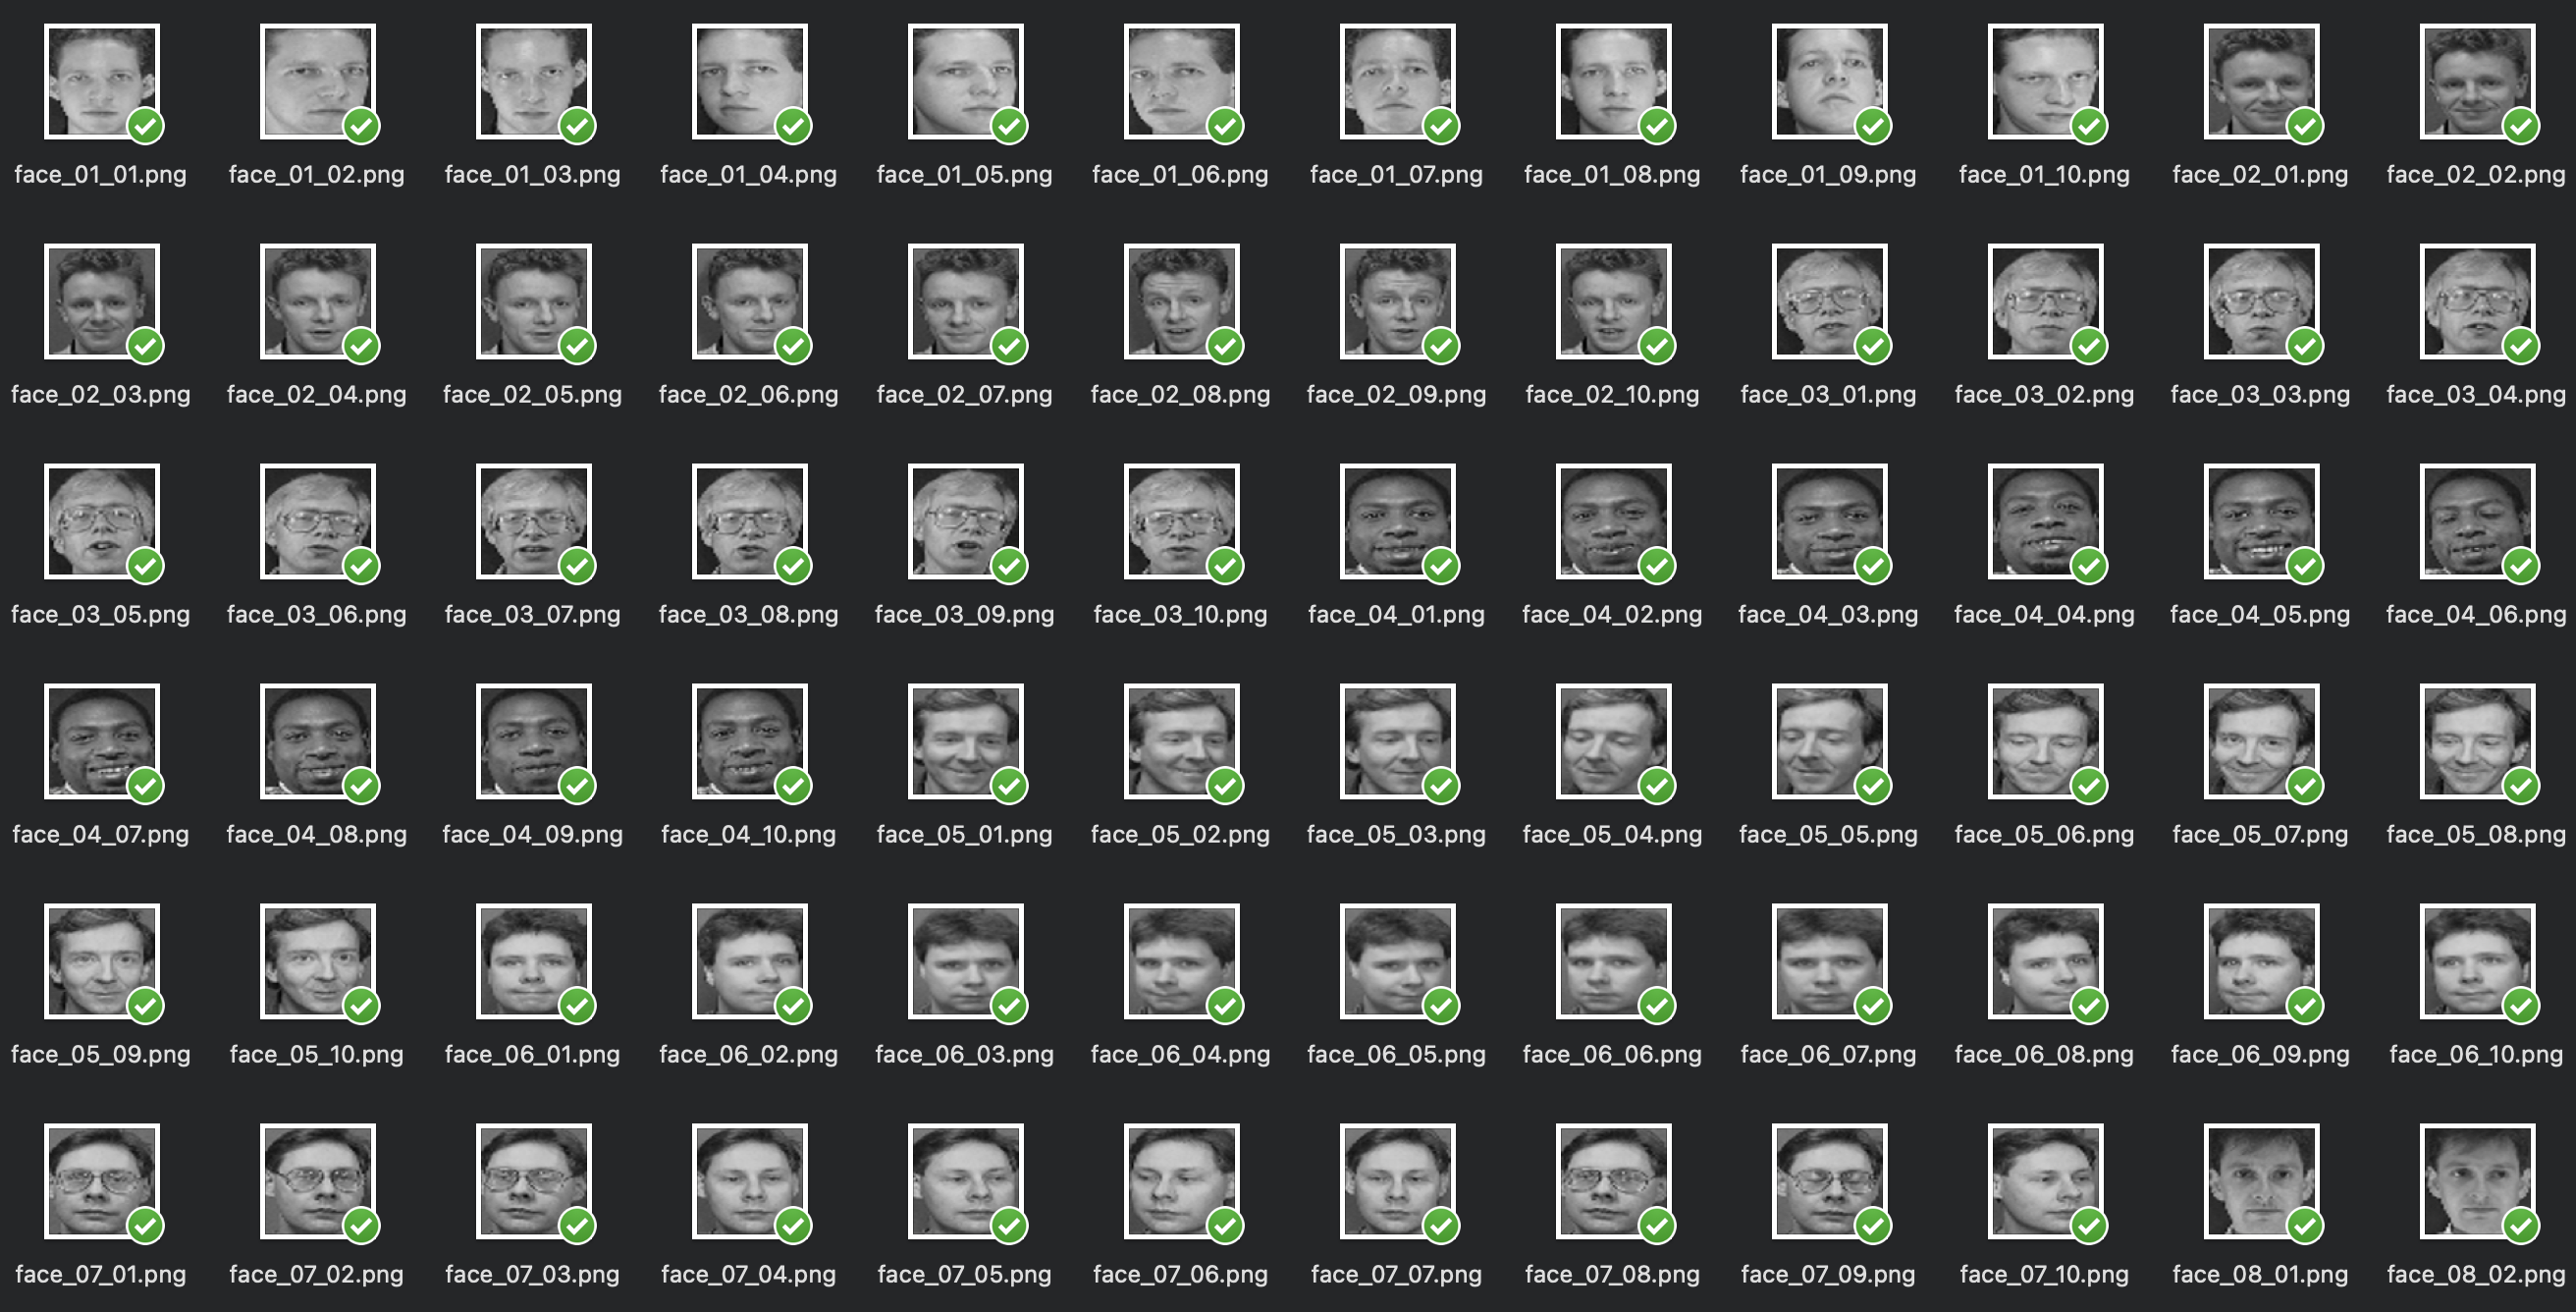

# Setup inicial

Liberías necesarias para que funcione el algoritmo.

## Instalación de PyXvis

PyXvis es una librería creada recientemente para el libro [Computer Vision for X-ray Testing](https://domingomery.ing.puc.cl/publications/book/) (Mery & Pieringer, Springer, 2021). En los ejemplos de este notebook, se utiliza esta librería sólo para la extracción de características. Por el momento. como la instalación de PyXvis usando 'pip install pyxvis' es inestable, usaremos esta instalación: 

In [ ]:
# Instalación de PyXvis

!wget https://www.dropbox.com/s/54jfodpv1h4d0kl/pyxvis.zip
!unzip pyxvis.zip
!rm pyxvis.zip
print('PyXvis library downloaded.')
!pip install scipy==1.2
!pip3 install pybalu==0.2.5
!pip install ./pyxvis
print('PyXvis library installed.')


## Setup de librerías

In [ ]:
import numpy as np
import cv2
from   sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from   seaborn import heatmap
from   google.colab.patches import cv2_imshow 
from   tqdm.auto import tqdm
from   pybalu.feature_extraction import lbp_features


# Carga de base de datos

La base de datos consiste en 40 clases y 10 imágenes por clase. Se almacenan en la carpeta ORL con el formato face_xx_nn.png, donde xx es el ID de la persona (01, 02, ... 40) y nn es el número de la foto de la persona (01, 02, ... 10). Las fotos son de 80x80 pixeles.

In [ ]:
# Carga de base de datos
!wget https://www.dropbox.com/s/utna2z7oqqn6jz2/ORL.zip
!unzip ORL.zip

# Funciones necesarias

In [ ]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix,num_char,num_img,echo='off'):
  st   = prefix + num2fixstr(num_char,2) + '_' + num2fixstr(num_img,2) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img

# Extracción de características LBP

In [ ]:
K    = 40   # número de clases
N    = 10   # número de imágenes por clase
hdiv = 4    # número de particiones horizontales
vdiv = 4    # número de particiones verticales
M    = hdiv*vdiv*59 # número de características por imagen

X = np.zeros((K*N,M))               # K x N muestras (filas), y M características (columnas)
y = np.zeros((K*N),'int')           # ground truth (clasificacion ideal)

t = 0
print('Cargando imagenes ORL y extrayendo características LBP...')
for j in tqdm(range(K)):            # para cada clase
  for i in range(N):                # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('ORL/face_',j+1,i+1,echo='off')
    # Extracción de características
    f = lbp_features(img, hdiv=hdiv, vdiv=vdiv, mapping='nri_uniform')
    # Normalización
    f = f/np.linalg.norm(f)
    # Almacenamiento        
    X[t,:] = f
    y[t] = j
    t = t+1


# Visualización de distribución de clases

# Matriz de similitud

Como cada caracter ha sido descrito como un vector de M elementos (para 4x4 divisiones, M = 4x4x59 = 944 elementos) de norma uno, se puede realizar un producto punto de todos con todos. De esta manera los productos que sean cercanos a 1 indican que esos vectores son similares.

En esste ejemplo, en la matriz X de 400xM elementos, existen 10 vectores por cada persona, de esta manera los productos punto entre vectores de la misma clase deben dar cercanos a 1 (toda la diagonal es 1.0), mientras que los productos punto de vectores entre distintas clases deben dar valores mucho menores que 1.

In [ ]:
D      = np.dot(X,X.T)
fig    = plt.figure()
ax     = fig.add_subplot(111)
implot = plt.imshow(D,cmap='jet') 

En este mapa de calor, colores parecidos al rojo indican valores cercanos a 1, mientras que colores cercanos al azul indican valores cercanos a 0.

# Clasificación

Un clasificador podría diseñarse usando el vecino más cercano (conocido como KNN con k=1). 

Pero antes de diseñar el clasificador, debemos hacer la separación de los datos en subset de Training y substets de Testing. En este ejemplo usamos 90% para el training y 10% para el testing separados de la siguiente manera:

* Training: las imágenes 1, 2, ... 9 de cada persona

* Testing: la imagen 0 de cada persona

In [ ]:
# Separación entre training y testing
# Se escoge la primera foto de cada persona para testing, el resto para training

Xtrain = np.zeros((K*(N-1),M))  # 9 fotos por persona para training
ytrain = np.zeros((K*(N-1)),'int')
Xtest  = np.zeros((K,M))    # 1 foto por persona para testing
ytest  = np.zeros((K),'int')

itest  = 0                   # imagen escogida para testing, puede ser 0,1,..9

ktrain = 0                   # contador para Xtrain
ktest  = 0                   # contador para Xtest
for i in range(400):
  if np.mod(i,10)==itest:
    Xtest[ktest,:] = X[i,:]
    ytest[ktest]   = y[i]
    ktest = ktest+1
  else:
    Xtrain[ktrain,:] = X[i,:]
    ytrain[ktrain]   = y[i]
    ktrain = ktrain+1


# Clasificación usando 'Vecino más cercano'

La idea del vecino más cercano es buscar para cada LBP del testing el LBP del training más parecido y escoger su clase.

Una forma sencilla de evaluar la similitud es a través del producto punto. Como los vectores tienen norma 1, los vectores parecidos tendrán un producto punto alto (cercano a 1).

Para implementar esto hacemos el producto matricial de Xtrain con la transpuesta de Xtest. El resultado es una matriz Z cuyo elemento (i,j) denota el producto punto del LBP i del training con el LBP j del testing.

Es decir, la columna j de Z contiene el producto punto del LBP j del testing con los 360 LBP del training. El algoritmo de clasificación consiste entonces en buscar el máximo de la columna j de Z y asignarle a la muestra j del testing la clase que tiene la muestra del training donde se encontró el máximo. 

En nuestro código, el máximo de la columna j de z se almacena en la variable k, entonces la muestra j del testing se clasifica como ytrain[k].

In [ ]:
# Clasificación usando el vecino más cercano (conocido como KNN con k=1)
Z = np.dot(Xtrain,Xtest.T)
ypred = np.zeros((K))
for j in range(K): # K clases, K imágenes de testing
  z = Z[:,j]       # vector de 360 elementos: producto punto de Xtest[j,:] con todas los LBP del training
  k = np.where(z==z.max()) # se busca en el training el más parecido a la muestra de testing j
  ypred[j] = ytrain[k]     # clasificación: se escoge la clase que tiene la muestra de training más parecida al testing

print('Clasificación de '+str(K)+' imágenes de testing realizada.')

# Evaluación de desempeño

In [ ]:
acc = accuracy_score(ytest,ypred)
print('Testing Accuracy = '+str(acc*100)+'%')

In [ ]:
C = confusion_matrix(ytest,ypred)
print('Matriz de Confusión:')
heatmap(C, cmap="YlGnBu")

# Visualización de imágenes mal clasificadas

In [ ]:
for i in range(K):
  for j in range(K):
    if i!=j and C[i,j]>0:
      # Imagen de testing
      I     = ImageLoad('ORL/face_',i+1,itest+1,echo='off')      
      # Imágenes de training
      ini = 1
      for k in range(10):
        if k!=itest:
          Jk  = ImageLoad('ORL/face_',j+1,k+1,echo='off')
          if ini==1:
            ini = 0
            J = Jk
          else:
            J = cv2.hconcat([J,Jk])
      print('Error de Clasificación: se confundió persona '+str(i+1)+' (foto de testing)...')
      cv2_imshow(I*255)
      print('... ya que fue clasificada como persona '+str(j+1)+' (fotos de training):')
      #implot = plt.imshow(IJ,cmap='gray')
      cv2_imshow(J*255)
      print('---------------------------------------------')
      
      